In [69]:
import os
import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
# to see the whole dataframe
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv(r"C:\Users\Cyrus\Documents\Data Projects\bbc nlp\data\sport\sport.csv")
df.head(10)

,Category,Text,Filename,Subcategory
0,sport,"Claxton hunting first major medal\n\nBritish hurdler Sarah Claxton is confident she can win her first major medal at next month's European Indoor Championships in Madrid.\n\nThe 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. ""I am quite confident,"" said Claxton. ""But I take each race as it comes. ""As long as I keep up my training but not do too much I think there is a chance of a medal."" Claxton has won the national 60m hurdles title for the past three years but has struggled to translate her domestic success to the international stage. Now, the Scotland-born athlete owns the equal fifth-fastest time in the world this year. And at last week's Birmingham Grand Prix, Claxton left European medal favourite Russian Irina Shevchenko trailing in sixth spot.\n\nFor the first time, Claxton has only been preparing for a campaign over the hurdles - which could explain her leap in form. In previous seasons, the 25-year-old also contested the long jump but since moving from Colchester to London she has re-focused her attentions. Claxton will see if her new training regime pays dividends at the European Indoors which take place on 5-6 March.\n",data/sport/001.txt,NaN
1,sport,"O'Sullivan could run in Worlds\n\nSonia O'Sullivan has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne.\n\nAthletics Ireland have hinted that the 35-year-old Cobh runner may be included in the official line-up for the event in France on 19-20 March. Provincial teams were selected after last Saturday's Nationals in Santry and will be officially announced this week. O'Sullivan is at present preparing for the London marathon on 17 April. The participation of O'Sullivan, currentily training at her base in Australia, would boost the Ireland team who won the bronze three years agio. The first three at Santry last Saturday, Jolene Byrne, Maria McCambridge and Fionnualla Britton, are automatic selections and will most likely form part of the long-course team. O'Sullivan will also take part in the Bupa Great Ireland Run on 9 April in Dublin.\n",data/sport/002.txt,NaN
2,sport,"Greene sets sights on world title\n\nMaurice Greene aims to wipe out the pain of losing his Olympic 100m title in Athens by winning a fourth World Championship crown this summer.\n\nHe had to settle for bronze in Greece behind fellow American Justin Gatlin and Francis Obikwelu of Portugal. ""It really hurts to look at that medal. It was my mistake. I lost because of the things I did,"" said Greene, who races in Birmingham on Friday. ""It's never going to happen again. My goal - I'm going to win the worlds."" Greene crossed the line just 0.02 seconds behind Gatlin, who won in 9.87 seconds in one of the closest and fastest sprints of all time. But Greene believes he lost the race and his title in the semi-finals. ""In my semi-final race, I should have won the race but I was conserving energy. ""That's when Francis Obikwelu came up and I took third because I didn't know he was there. ""I believe that's what put me in lane seven in the final and, while I was in lane seven, I couldn't feel anything in the race.\n\n""I just felt like I was running all alone. ""I believe if I was in the middle of the race I would have been able to react to people that came ahead of me."" Greene was also denied Olympic gold in the 4x100m men's relay when he could not catch Britain's Mark Lewis-Francis on the final leg. The Kansas star is set to go head-to-head with Lewis-Francis again at Friday's Norwich Union Grand Prix. The pair contest the 60m, the distance over which Greene currently holds the world record of 6.39 seconds. He then has another indoor meeting in France before resuming training for the outdoor season and the task of recapturing his world title in Helsinki in August. Greene believes Gatlin will again prove th

In [72]:
df.head()

,Category,Text,Filename,Subcategory
0,sport,"Claxton hunting first major medal\n\nBritish hurdler Sarah Claxton is confident she can win her first major medal at next month's European Indoor Championships in Madrid.\n\nThe 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. ""I am quite confident,"" said Claxton. ""But I take each race as it comes. ""As long as I keep up my training but not do too much I think there is a chance of a medal."" Claxton has won the national 60m hurdles title for the past three years but has struggled to translate her domestic success to the international stage. Now, the Scotland-born athlete owns the equal fifth-fastest time in the world this year. And at last week's Birmingham Grand Prix, Claxton left European medal favourite Russian Irina Shevchenko trailing in sixth spot.\n\nFor the first time, Claxton has only been preparing for a campaign over the hurdles - which could explain her leap in form. In previous seasons, the 25-year-old also contested the long jump but since moving from Colchester to London she has re-focused her attentions. Claxton will see if her new training regime pays dividends at the European Indoors which take place on 5-6 March.\n",data/sport/001.txt,NaN
1,sport,"O'Sullivan could run in Worlds\n\nSonia O'Sullivan has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne.\n\nAthletics Ireland have hinted that the 35-year-old Cobh runner may be included in the official line-up for the event in France on 19-20 March. Provincial teams were selected after last Saturday's Nationals in Santry and will be officially announced this week. O'Sullivan is at present preparing for the London marathon on 17 April. The participation of O'Sullivan, currentily training at her base in Australia, would boost the Ireland team who won the bronze three years agio. The first three at Santry last Saturday, Jolene Byrne, Maria McCambridge and Fionnualla Britton, are automatic selections and will most likely form part of the long-course team. O'Sullivan will also take part in the Bupa Great Ireland Run on 9 April in Dublin.\n",data/sport/002.txt,NaN
2,sport,"Greene sets sights on world title\n\nMaurice Greene aims to wipe out the pain of losing his Olympic 100m title in Athens by winning a fourth World Championship crown this summer.\n\nHe had to settle for bronze in Greece behind fellow American Justin Gatlin and Francis Obikwelu of Portugal. ""It really hurts to look at that medal. It was my mistake. I lost because of the things I did,"" said Greene, who races in Birmingham on Friday. ""It's never going to happen again. My goal - I'm going to win the worlds."" Greene crossed the line just 0.02 seconds behind Gatlin, who won in 9.87 seconds in one of the closest and fastest sprints of all time. But Greene believes he lost the race and his title in the semi-finals. ""In my semi-final race, I should have won the race but I was conserving energy. ""That's when Francis Obikwelu came up and I took third because I didn't know he was there. ""I believe that's what put me in lane seven in the final and, while I was in lane seven, I couldn't feel anything in the race.\n\n""I just felt like I was running all alone. ""I believe if I was in the middle of the race I would have been able to react to people that came ahead of me."" Greene was also denied Olympic gold in the 4x100m men's relay when he could not catch Britain's Mark Lewis-Francis on the final leg. The Kansas star is set to go head-to-head with Lewis-Francis again at Friday's Norwich Union Grand Prix. The pair contest the 60m, the distance over which Greene currently holds the world record of 6.39 seconds. He then has another indoor meeting in France before resuming training for the outdoor season and the task of recapturing his world title in Helsinki in August. Greene believes Gatlin will again prove th

In [73]:
# Check dataset shape
print("Shape:", df.shape)

# Null values
print("\nNull values:")
print(df.isnull().sum())

# Duplicate rows
print("\nDuplicates:", df.duplicated().sum())

# Count duplicates only in the Text column
dup_text_count = df["Text"].duplicated().sum()
print("Duplicate Text rows:", dup_text_count)

# Show the actual duplicate texts (if any)
dup_texts = df[df["Text"].duplicated(keep=False)].sort_values("Text")
print(dup_texts)



Shape: (511, 4)

Null values:
Category         0
Text             0
Filename         0
Subcategory    511
dtype: int64

Duplicates: 0
Duplicate Text rows: 6
    Category  \
334    sport   
407    sport   
11     sport   
19     sport   
251    sport   
254    sport   
429    sport   
435    sport   
51     sport   
83     sport   
256    sport   
257    sport   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Remove Duplicate Texts

In [74]:
# Drop duplicates in the Text column, keep first occurrence
df = df.drop_duplicates(subset=["Text"]).reset_index(drop=True)

print("After dropping duplicate texts:", df.shape)
print("Remaining duplicates in Text:", df["Text"].duplicated().sum())


After dropping duplicate texts: (505, 4)
Remaining duplicates in Text: 0


Filter Out Very Short News

In [75]:
# Add word count column
df["word_count"] = df["Text"].apply(lambda x: len(x.split()))

# Drop very short texts (e.g., < 30 words)
df = df[df["word_count"] > 30].reset_index(drop=True)

print("After filtering short docs:", df.shape)

After filtering short docs: (505, 5)


Data Cleaning 

In [ ]:
import re

# Cleaning function
def clean_text(text):
    """
    Lightly cleans raw news text for embeddings:
    - Removes extra line breaks/tabs
    - Normalizes common quotes/apostrophes
    - Keeps punctuation (! ? : ; - / @ &) since LLM embeddings benefit from context
    - Collapses multiple spaces
    """
    # 1. Remove line breaks & tabs
    text = text.replace("\n", " ").replace("\t", " ")

    # 2. Normalize quotes/apostrophes
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"[‘’]", "'", text)

    # 3. Keep most punctuation, only strip weird unicode
    text = re.sub(r"[^\x00-\x7F]+", " ", text)  # remove non-ASCII symbols

    # 4. Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


# Apply function to df
def clean_dataframe(df):
    if "Text" not in df.columns:
        raise KeyError("DataFrame must have a 'Text' column")

    df["Clean_Text"] = df["Text"].astype(str).apply(clean_text)
    df = df[df["Clean_Text"].str.strip() != ""].reset_index(drop=True)

    return df


# Example run
df_clean = clean_dataframe(df)
print(df_clean[["Category", "Clean_Text"]].head(3))


  Category  \
0    sport   
1    sport   
2    sport   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [77]:
df.head()

,Category,Text,Filename,Subcategory,word_count,Clean_Text
0,sport,"Claxton hunting first major medal\n\nBritish hurdler Sarah Claxton is confident she can win her first major medal at next month's European Indoor Championships in Madrid.\n\nThe 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. ""I am quite confident,"" said Claxton. ""But I take each race as it comes. ""As long as I keep up my training but not do too much I think there is a chance of a medal."" Claxton has won the national 60m hurdles title for the past three years but has struggled to translate her domestic success to the international stage. Now, the Scotland-born athlete owns the equal fifth-fastest time in the world this year. And at last week's Birmingham Grand Prix, Claxton left European medal favourite Russian Irina Shevchenko trailing in sixth spot.\n\nFor the first time, Claxton has only been preparing for a campaign over the hurdles - which could explain her leap in form. In previous seasons, the 25-year-old also contested the long jump but since moving from Colchester to London she has re-focused her attentions. Claxton will see if her new training regime pays dividends at the European Indoors which take place on 5-6 March.\n",data/sport/001.txt,NaN,211,"Claxton hunting first major medal British hurdler Sarah Claxton is confident she can win her first major medal at next month's European Indoor Championships in Madrid. The 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. ""I am quite confident,"" said Claxton. ""But I take each race as it comes. ""As long as I keep up my training but not do too much I think there is a chance of a medal."" Claxton has won the national 60m hurdles title for the past three years but has struggled to translate her domestic success to the international stage. Now, the Scotland-born athlete owns the equal fifth-fastest time in the world this year. And at last week's Birmingham Grand Prix, Claxton left European medal favourite Russian Irina Shevchenko trailing in sixth spot. For the first time, Claxton has only been preparing for a campaign over the hurdles - which could explain her leap in form. In previous seasons, the 25-year-old also contested the long jump but since moving from Colchester to London she has re-focused her attentions. Claxton will see if her new training regime pays dividends at the European Indoors which take place on 5-6 March."
1,sport,"O'Sullivan could run in Worlds\n\nSonia O'Sullivan has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne.\n\nAthletics Ireland have hinted that the 35-year-old Cobh runner may be included in the official line-up for the event in France on 19-20 March. Provincial teams were selected after last Saturday's Nationals in Santry and will be officially announced this week. O'Sullivan is at present preparing for the London marathon on 17 April. The participation of O'Sullivan, currentily training at her base in Australia, would boost the Ireland team who won the bronze three years agio. The first three at Santry last Saturday, Jolene Byrne, Maria McCambridge and Fionnualla Britton, are automatic selections and will most likely form part of the long-course team. O'Sullivan will also take part in the Bupa Great Ireland Run on 9 April in Dublin.\n",data/sport/002.txt,NaN,144,"O'Sullivan could run in Worlds Sonia O'Sullivan has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne. Athletics Ireland have hinted that the 35-year-old Cobh runner may be included in the official line-up for the event in France on 19-20 March. Provincial teams were selected after last Saturday's Nationals in Santry and will be officially announced this week. O'Sullivan is at present preparing for the L

In [ ]:
# Check if GPU is available
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


Embedding each article with OpenAI

In [ ]:
import pandas as pd
import hdbscan
from sklearn.metrics.pairwise import cosine_distances
from openai import OpenAI
import json
import random

# Setup client
client = OpenAI(api_key="")


# Embedding 
def get_embedding(text, model="text-embedding-3-large"):
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding


#Labeling with GPT (Sports) 
def label_cluster(docs):
    """Label a group of sports documents with broad reusable categories"""
    sample_text = "\n---\n".join(docs[:3])  # up to 3 docs
    prompt = f"""
You are a topic labeling assistant. 
Your task is to assign a broad, reusable subtopic label.

Here are some example sports news articles from the same cluster:
{sample_text}

Guidelines:
- Labels must be broad enough to apply to many similar texts.  
- Use **general categories** like "Football", "Cricket", "Rugby", "Olympics", "Tennis", etc.  
- Avoid overly specific match names or one-off labels.  
- Keep labels **1–3 words maximum**.  
- Prefer terms that can group other articles in the same domain.  

Respond in JSON format: {{"label": "your label here"}}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    try:
        return json.loads(response.choices[0].message.content)["label"]
    except:
        return response.choices[0].message.content.strip()


def label_single_doc(text):
    """Label a sports article with predefined categories, with flexibility for new ones"""
    first_sentence = text.split(".")[0]
    prompt = f"""You are a topic labeling assistant.
Your task is to assign a broad reusable subtopic label for a sports news article.

Here is a news snippet:
{first_sentence}

Guidelines:
- Prefer one of these predefined sports categories if possible:
  ["Football", "Cricket", "Rugby", "Olympics", "Tennis", "Formula 1","Track & Field"]  
- If the text does not fit any of these, propose a concise new label (1–3 words).  
- Keep labels broad, reusable, and no more than 3 words.  
- Avoid event-specific or one-off names.  

Respond in JSON format: {{"label": "your label here"}}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    try:
        return json.loads(response.choices[0].message.content)["label"]
    except:
        return response.choices[0].message.content.strip()


In [ ]:
# Main loop
results = []

for cat, group in df.groupby("Category"):
    print(f"\nProcessing category: {cat}, n={len(group)}")

    # Step 1: Embeddings
    group["embedding"] = group["Clean_Text"].apply(get_embedding)
    X = np.array(group["embedding"].to_list())

    # Step 2: Cosine distance
    cosine_dist = cosine_distances(X)

    # Step 3: HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=5,
        min_samples=3,
        metric="precomputed",
        cluster_selection_method="leaf"
    )
    group["Subcluster"] = clusterer.fit_predict(cosine_dist)

    # Step 4: Label clusters
    cluster_labels = {}
    for cluster_id in set(group["Subcluster"]):
        docs = group[group["Subcluster"] == cluster_id]["Clean_Text"].tolist()
        
        if cluster_id == -1:  
            # Noise → label individually
            for idx, doc in group[group["Subcluster"] == -1].iterrows():
                group.at[idx, "Subtopic_Label"] = label_single_doc(doc["Clean_Text"])
        else:
            # Label real clusters
            sample_docs = random.sample(docs, min(3, len(docs)))
            cluster_labels[cluster_id] = label_cluster(sample_docs)
            group.loc[group["Subcluster"] == cluster_id, "Subtopic_Label"] = cluster_labels[cluster_id]

    results.append(group)

# Final combined dataframe
df_subtopics = pd.concat(results).reset_index(drop=True)

# Preview
print(df_subtopics[["Category", "Subcluster", "Subtopic_Label", "Clean_Text"]].head(20))





Processing category: sport, n=505
   Category  Subcluster Subtopic_Label  \
0     sport          -1  Track & Field   
1     sport          -1  Track & Field   
2     sport          -1  Track & Field   
3     sport          -1  Track & Field   
4     sport          -1  Track & Field   
5     sport          -1  Track & Field   
6     sport          -1  Track & Field   
7     sport          -1  Track & Field   
8     sport          14      Athletics   
9     sport          14      Athletics   
10    sport          12      Athletics   
11    sport          -1  Track & Field   
12    sport          13      Athletics   
13    sport          -1  Track & Field   
14    sport          -1  Track & Field   
15    sport           7      Athletics   
16    sport           7      Athletics   
17    sport          -1  Track & Field   
18    sport          13      Athletics   
19    sport          13      Athletics   

                                                                                  

In [81]:
summary = df_subtopics.groupby(["Category", "Subtopic_Label"]).size().reset_index(name="Count")
print(summary.sort_values("Count", ascending=False).head(20))


  Category     Subtopic_Label  Count
2    sport           Football    187
6    sport              Rugby    133
7    sport             Tennis     89
0    sport          Athletics     49
9    sport      Track & Field     35
1    sport     Doping Scandal      8
3    sport  Football Security      1
4    sport     General Sports      1
5    sport           Olympics      1
8    sport      Tennis Doping      1


In [82]:
top_subtopics = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

# Get top 5 per category
top5_per_category = top_subtopics.groupby("Category").head(5)
print(top5_per_category)


  Category Subtopic_Label  Count
2    sport       Football    187
6    sport          Rugby    133
7    sport         Tennis     89
0    sport      Athletics     49
9    sport  Track & Field     35


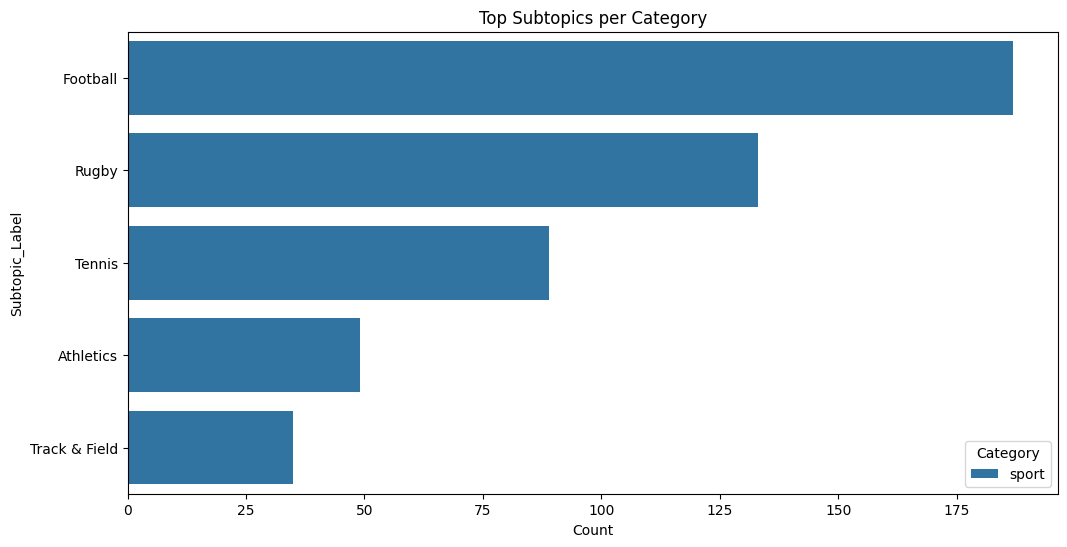

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    data=top5_per_category,
    x="Count", y="Subtopic_Label", hue="Category"
)
plt.title("Top Subtopics per Category")
plt.show()


We can regex clean those:

In [85]:
import re

def clean_label(label):
    if not isinstance(label, str):
        return label
    # If GPT returned JSON-like text, extract inside
    match = re.search(r'"label"\s*:\s*"([^"]+)"', label)
    if match:
        return match.group(1)
    return label.strip()

df_subtopics["Subtopic_Label"] = df_subtopics["Subtopic_Label"].apply(clean_label)

Rerunning the summary

In [86]:
summary = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

top5_per_category = summary.groupby("Category").head(5)
print(top5_per_category)


  Category Subtopic_Label  Count
2    sport       Football    187
6    sport          Rugby    133
7    sport         Tennis     89
0    sport      Athletics     49
9    sport  Track & Field     35


save the full results into a DataFrame and export to CSV for further analysis or visualization.

In [87]:
import pandas as pd

# Ensure df_subtopics already has:
# Category, Subcluster, Subtopic_Label, Clean_Text

# Save the full detailed dataset
df_subtopics.to_csv("bbc_sport_subtopics_full.csv", index=False)

# Also save the summarized counts per category/subtopic
summary = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)
summary.to_csv("bbc_sport_subtopics_summary.csv", index=False)

print("✅ Files saved:")
print(" - bbc_subtopics_full.csv  (all rows with labels)")
print(" - bbc_subtopics_summary.csv  (aggregated counts)")


✅ Files saved:
 - bbc_subtopics_full.csv  (all rows with labels)
 - bbc_subtopics_summary.csv  (aggregated counts)
